In [ ]:
# Module and class setup.

import numpy as np
import copy
import matplotlib.pyplot as plt

def flat_fes(x_vals):
    fes = np.zeros_like(x_vals)
    fes -= fes.min()
    return fes

def shallow_fes(x_vals):
    fes = x_vals**4 - 0.85*x_vals**2
    fes -= fes.min()
    return fes

def deep_fes(x_vals):
    fes = 100*x_vals**4 - 100*x_vals**2
    fes -= fes.min()
    return fes

def harmonic_restraint(x_vals,center,kappa):
        return 0.5 * kappa * (x_vals - center)**2

class Dynamics():
    def __init__(self, fes_func):

        self.x_vals = np.linspace(-1,1,100)
        self.bin_width = self.x_vals[1] - self.x_vals[0]
        self.fes_func = fes_func
        self.underlying_fes = fes_func(self.x_vals)
        
        self.boltz_weights = np.exp(-self.underlying_fes)

        self.underlying_prob_dist = self.boltz_weights / (np.sum(self.boltz_weights)*self.bin_width)

    def dynamics(self,nsteps):
        x_index = np.where(self.underlying_fes == self.underlying_fes.min())[0][0]
        coord = self.x_vals[x_index]
        self.time = [0]
        self.trajectory = [coord]
        num_acceptances = 0

        for i in range(nsteps):
            rand = np.random.rand()
            self.time.append(i+1)
            
            if rand >= 0.5:
                # Impose PBC
                if (x_index + 1) == 100:
                    trial_index = 0

                else:
                    trial_index = x_index + 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            else:
                # Impose PBC
                if (x_index - 1) == -1:
                    trial_index = 99

                else:
                    trial_index = x_index - 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            coord = self.x_vals[x_index]
            
            self.trajectory.append(coord)
        
        self.acceptance_prob = num_acceptances / nsteps

    def calc_unbiased_prob(self):
        hist, _ = np.histogram(self.trajectory,range=(-1,1),bins=100)

        self.prob_hist = hist/(hist.sum()*self.bin_width)
        weights = np.exp(self.bias,dtype='float128')
        self.unbiased_prob = self.prob_hist*weights

class Umbrella_sampling():
    def __init__(self,numbrellas,kappa,fes_func):

        self.numbrellas = numbrellas
        self.centers = np.linspace(-1,1,numbrellas)
        self.replicas = []
        for i in range(numbrellas):
            replica_window = Dynamics(fes_func)
            replica_window.bias = harmonic_restraint((replica_window.x_vals),(self.centers[i]),kappa)
            replica_window.underlying_fes += replica_window.bias
            replica_window.boltz_weights = np.exp(-replica_window.underlying_fes)
            replica_window.underlying_prob_dist = replica_window.boltz_weights / (np.sum(replica_window.boltz_weights)*replica_window.bin_width)
            self.replicas.append(copy.deepcopy(replica_window))

    def dynamics(self,nsteps):
        self.nsteps = nsteps
        for i in range(self.numbrellas):
            self.replicas[i].dynamics(nsteps)

    
class WHAM():
    def __init__(self,umb_sim,iterations):

        self.umb_sim = umb_sim
        self.f = np.ones(umb_sim.numbrellas)
        self.N = np.ones_like(self.f)*umb_sim.nsteps # This is incorrect, in principle, because the samples are correlated.
        self.c = np.array([np.exp(-window.bias) for window in umb_sim.replicas])

        n = []
        for window in umb_sim.replicas:
            hist, _ = np.histogram(window.trajectory,range=(-1,1),bins=100)
            n.append(hist)
        self.n = np.array(n)

        for i in range(iterations):
            self.calc_p()
            self.calc_f()

        self.calc_G()

    def calc_p(self):
        numerator = np.sum(self.n,axis=0)
        denominator = np.sum((self.N*self.f*self.c.T).T,axis=0)
        self.p = numerator / denominator

    def calc_f(self):
        self.f = 1 / np.sum(self.c*self.p,axis=1)

    def calc_G(self):
        self.G = -np.log(self.p)

## Free energy as a function of a collective variable.

As we have learned in class, the "Free Energy" of a given microstate of a system is really just a measurement of how likely that microstate is. When in the canonical ensemble (i.e. NVT are constant), this is known as the Helmholtz Free Energy (often denoted by $F$ or $A$). When in the isobaric-isothermal ensemble (i.e. NPT are constant), this quantity is known as the Gibbs free energy ($G$). I will make the (hopefully unoffensive) assumption that the reader identifies more as a chemist than a physicist, and thus more often deals with systems that are under constant pressure. For this reason, I will label the "free energy" as $G$ in the equations that follow. It is worth noting, however, that all of these equations hold in the canonical ensemble by simply swapping $G$ for $F$, so long as one bears in mind that Gibbs and Helmholtz free energies are fundamentally different from one another.

There is a single simple equation that relates the free energy to the probability of a state (see Appendix I for the derivation):

$$G(\mathbf{q}) = -k_BT\ln{P(\mathbf{q})}$$

where $\mathbf{q}$ are the microscopic coordinates of the system (i.e. positions and momenta of particles), $T$ is the temperature in Kelvin, and $k_B$ is the Boltzmann constant with units of energy-per-Kelvin. Again, assuming we're all chemists here, the energies are often reported in per-molar quantities, and in particular, $kJ/mol$ and $kcal/mol$ tend to be of a nice scale for analyzing the types of transitions we're interested in.

Written as functions of $\mathbf{q}$, $G$ and $P$ are $6N$-dimensional quantities, where $N$ is the number of particles in the system. This is seldom useful because of how impossible it becomes to sample such a high-dimensional phase space. Instead we pick some particular degrees of freedom that we are interested in from our simulation. Perhaps you are interested in seeing the distance between two residues in a protein, or the dipole moment for a group of atoms. In the example for today, we study a dihedral angle. The important thing is simply that the so-called "collective variable" of interest can be computed as a function of the microscopic coordinates $\mathbf{q}$. From here, we can reduce the dimensionality of $P$ down to our one reaction coordinate ($s$) using the following equation:

$$P(s) = \int{P(\mathbf{q})\delta(s - s(\mathbf{q}))} \text{d}\mathbf{q}$$

But the truth is that this equation does not have much practical utility for us; it only serves to justify collective variable-based methods. The important thing is the intuition that the free energy can be computed as a function of any CV we want, as long as the CV can be calculated from the microscopic coordinates.

It follows naturally that the free energy can then also be described as a function of $s$:

$$G(s) = -k_BT\ln{{P(s)}}$$

## Exercise 1: Using samples from a simulation to estimate $P(s)$ and $G(s)$.

Let's say we want to compute the free energy barrier of some transition that our system will undergo. The use of collective variables makes this, at least in principle, very simple! At every step in our simulation, we compute the value of the $s(\mathbf{q})$ that we're interested in. We therefore record the trajectory of our simulation in CV space, and can bin those values into a histogram. If we normalize this histogram such that its total area is equal to 1, this serves as an estimate of $P(s)$.

Let's try it! The following cell of code will run a Metropolis Monte Carlo simulation that will sample phase space based on the underlying 1D free energy surface. (See Appendix 2 or look at the source code of the Dynamics class for more information on the algorithm used here.) The 1D free energy surface in this toy model is analogous to the free energy surface in CV space that one might obtain from an MC or MD simulation of a real system. Once you have run the simulation, plot the 

Text(0, 0.5, 'Free Energy')

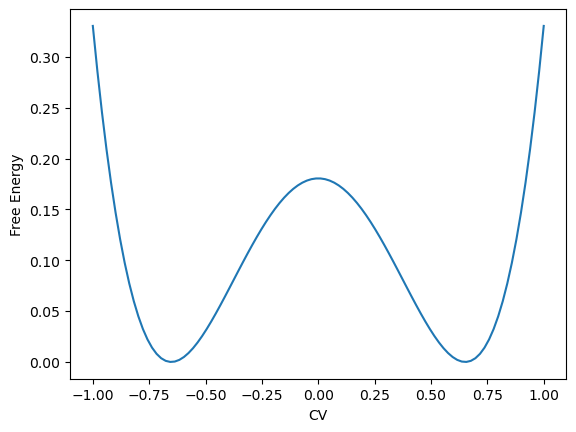

In [25]:
# Plot the underlying free energy of the simulation

x_vals = np.linspace(-1,1,100)
underlying_fes = shallow_fes(x_vals)
plt.plot(x_vals,underlying_fes)
plt.xlabel('CV')
plt.ylabel('Free Energy')

Text(0, 0.5, 'Probability')

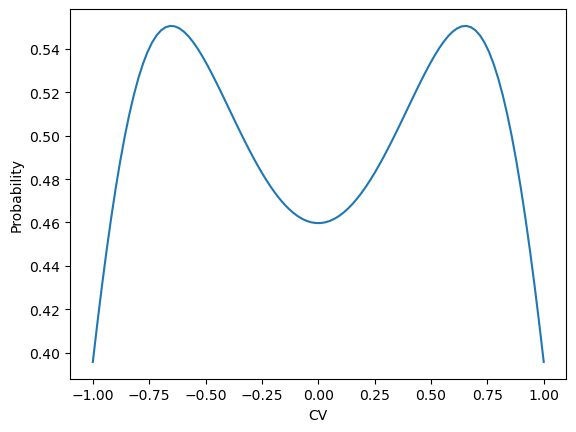

In [26]:
# In this cell, fill in the blank to compute the expected probability distribution from the underlying FES.
# Hint: To compute exponentials, you can use the np.exp() function implemented in numpy.

kBT = 1

underlying_prob = np.exp(-underlying_fes/kBT) # Your answer here
underlying_prob /= np.sum(underlying_prob*0.02) # We should always renormalize the probability distrubution to an area of 1

plt.plot(x_vals,underlying_prob)
plt.xlabel('CV')
plt.ylabel('Probability')

The next cell will run the simulation and plot the results against our underlying probability distribution.

In [ ]:
# Run the dynamics

dyn = Dynamics(fes_func=shallow_fes)
dyn.dynamics(10000000)

# Plot results

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(dyn.time,dyn.trajectory)
ax1.set_title('CV vs. Time')

hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100,density=True)
ax2 = fig.add_subplot(122)
ax2.plot(dyn.x_vals,underlying_prob,label='Underlying')
ax2.plot(dyn.x_vals,hist,label='Dynamics Estimate')
ax2.set_title('Probability Distribution')
ax2.legend()

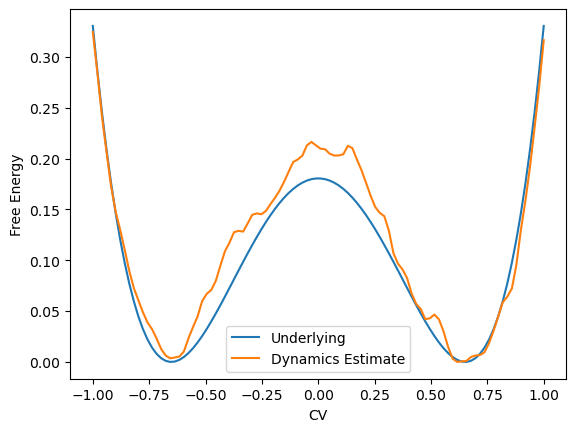

In [5]:
# Now fill in the blank to compute the estimate of the free energy surface from our simulation.
# Hint: Start by figuring out which variable from the previous cell represents the estimate of our probability distribution.

fes = -kBT * np.log(hist) # Fill in blank

plt.plot(x_vals,underlying_fes,label='Underlying')
plt.plot(x_vals,fes-fes.min(),label='Dynamics Estimate')
plt.xlabel('CV')
plt.ylabel('Free Energy')
plt.legend()

## Exercise 2: Overcoming high free-energy barriers.

Run the following cell to perform dynamics on an underlying free energy with a much higher barrier. What do you observe about the results?

In [31]:
dyn = Dynamics(fes_func=deep_fes)
dyn.dynamics(10000000)

/tmp/ipykernel_7415/1298786922.py:17: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(hist)


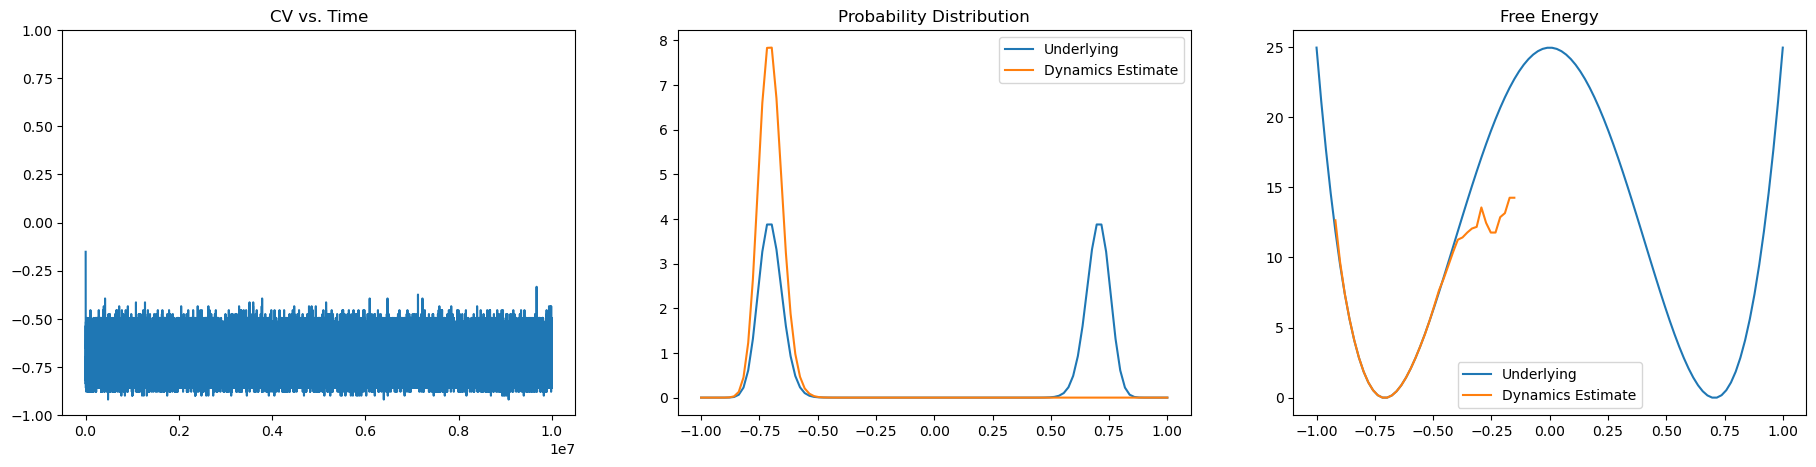

In [32]:
# Plot results of previous cell.

fig = plt.figure(figsize=(22.5,5))

ax1 = fig.add_subplot(131)
ax1.plot(dyn.time,dyn.trajectory)
ax1.set_title('CV vs. Time')
ax1.set_ylim(-1,1)

hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100,density=True)
ax2 = fig.add_subplot(132)
ax2.plot(dyn.x_vals,dyn.underlying_prob_dist,label='Underlying')
ax2.plot(dyn.x_vals,hist,label='Dynamics Estimate')
ax2.set_title('Probability Distribution')
ax2.legend()

fes = -np.log(hist)
ax3 = fig.add_subplot(133)
ax3.plot(dyn.x_vals,dyn.underlying_fes - dyn.underlying_fes.min(),label='Underlying')
ax3.plot(dyn.x_vals,fes-fes.min(),label='Dynamics Estimate')
ax3.set_title('Free Energy')
ax3.legend()

You can see that the random walk cannot overcome the free energy barrier in order to sample both free-energy minima, let alone sample the transition state itself. This is an extremely common problem with statistical sampling simulations. It would require an unfeasibly large number of steps (i.e., an extremely long computation time) in order to achieve a reasonable estimate for the underlying free energy of this system.

Thankfully, there are a huge number of methods for enhancing the sampling rate of simulations. We will look at two different ones today, the first known as "umbrella sampling", and the second being an extension of the umbrella sampling method known as the "weighted histogram analysis method", or "WHAM".

The idea behind umbrella sampling is simple. Let's run our dynamics again, but this time add a harmonic potential to our system that negates the energy barrier of the transition state. 

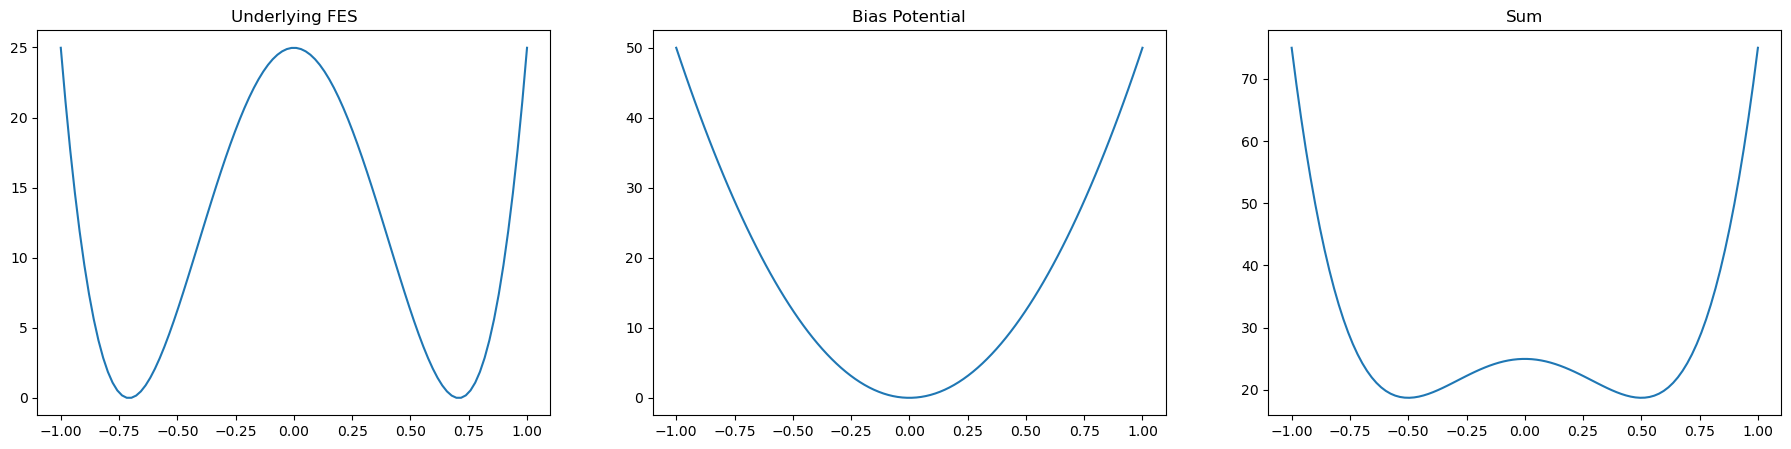

In [33]:
kappa = 100 # Play with kappa until you find a value that flattens the free energy surface nicely!

umb = Dynamics(fes_func=deep_fes)
underlying_fes = umb.underlying_fes.copy()

fig = plt.figure(figsize=(22.5,5))
ax1 = fig.add_subplot(131)
ax1.plot(umb.x_vals,underlying_fes)
ax1.set_title('Underlying FES')

bias_potential = harmonic_restraint(umb.x_vals,center=0,kappa=kappa)
ax2 = fig.add_subplot(132)
ax2.plot(umb.x_vals,bias_potential)
ax2.set_title('Bias Potential')

ax3 = fig.add_subplot(133)
ax3.plot(umb.x_vals,underlying_fes+bias_potential)
ax3.set_title('Sum')

umb.underlying_fes += bias_potential
umb.boltz_weights = np.exp(-umb.underlying_fes)
umb.underlying_prob_dist = umb.boltz_weights / (np.sum(umb.boltz_weights)*umb.bin_width)

Once you are happy with the value of kappa you've chosen, run the dynamics again.

In [36]:
umb.dynamics(10000000)

/tmp/ipykernel_7415/3393564082.py:17: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(hist)


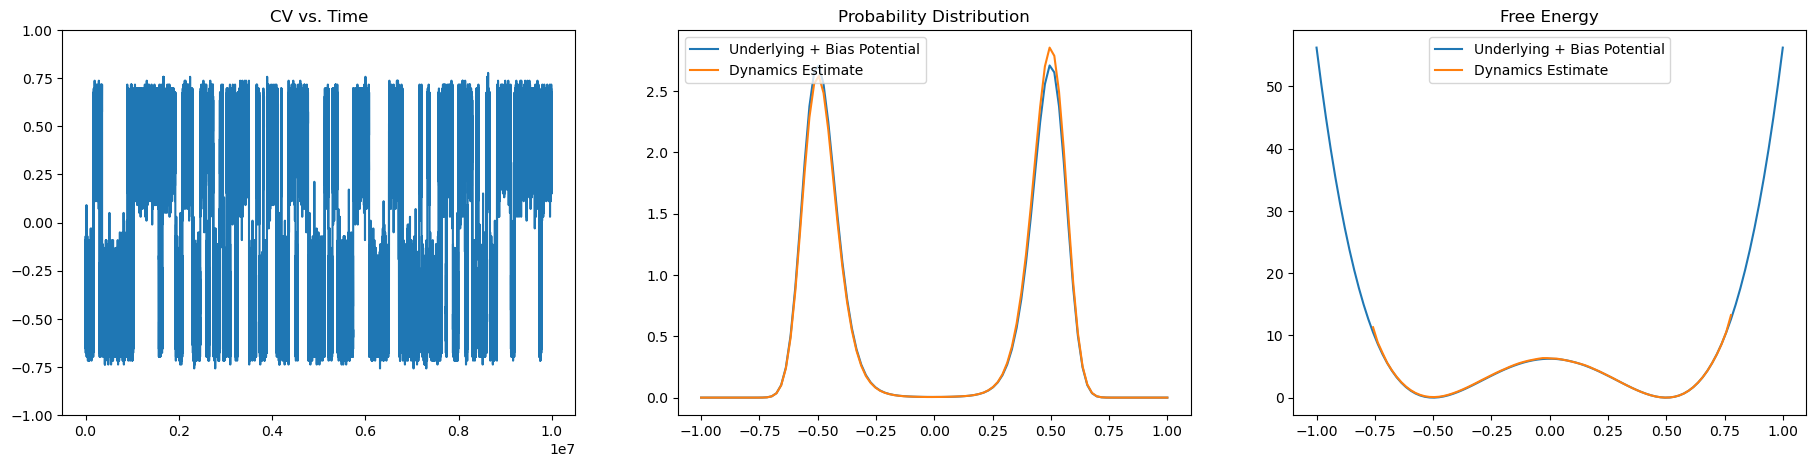

In [37]:
# Plot results from previous cell

fig = plt.figure(figsize=(22.5,5))

ax1 = fig.add_subplot(131)
ax1.plot(umb.time,umb.trajectory)
ax1.set_title('CV vs. Time')
ax1.set_ylim(-1,1)

hist, _ = np.histogram(umb.trajectory,range=(-1,1),bins=100,density=True)
ax2 = fig.add_subplot(132)
ax2.plot(umb.x_vals,umb.underlying_prob_dist,label='Underlying + Bias Potential')
ax2.plot(umb.x_vals,hist,label='Dynamics Estimate')
ax2.set_title('Probability Distribution')
ax2.legend()

fes = -np.log(hist)
ax3 = fig.add_subplot(133)
ax3.plot(umb.x_vals,umb.underlying_fes - umb.underlying_fes.min(),label='Underlying + Bias Potential')
ax3.plot(umb.x_vals,fes-fes.min(),label='Dynamics Estimate')
ax3.set_title('Free Energy')
ax3.legend()

Assuming that you have chosen kappa well, your simulation should have sampled both free energy minima as well as the transition state. This likely came at the expense that you were not able to sample the edges of the box, which may or may not be fine in a real scenario, depending on the nature of the CV you've chosen for analysis.

Our simulation converging to the the sum of the free energy and the bias potential is a good first result, but we want to calculate the actual free energy. Luckily, the concept behind reweighting our trajectories to recover the true free energy is quite simple.

$$P_{b}(s) = e^{\big(\frac{-(G(s)+V(s))}{k_BT}\big)}$$

$$\ln P_{b}(s) = \bigg(\frac{-(G(s)+V(s))}{k_BT}\bigg)$$

$$-k_BT \ln P_{b}(s) = G(s)+V(s)$$

$$-k_BT \ln P_{b}(s) - V(s) = G(s)$$

Where $P_{b}(s)$ is the biased probability distribution that we sampled and $V(s)$ is the bias potential we applied.

/tmp/ipykernel_7415/4066997617.py:2: RuntimeWarning: divide by zero encountered in log
  fes = -kBT*np.log(hist) - bias_potential


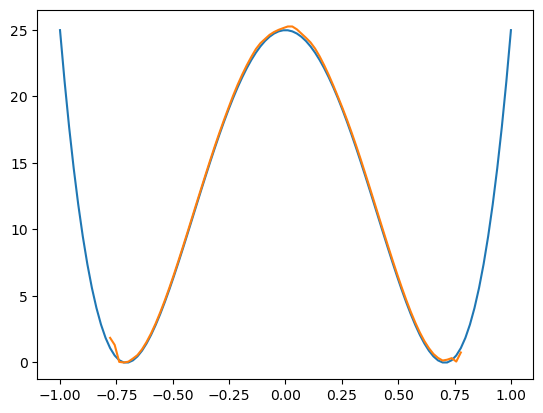

In [9]:
kBT = 1
fes = -kBT*np.log(hist) - bias_potential

plt.plot(umb.x_vals,underlying_fes-underlying_fes.min())
plt.plot(umb.x_vals,fes-fes.min())

## Exercise 3: Weighted Histogram Analysis Method

The original implementation of umbrella sampling, as described above, has some significant limitations. Firstly, in a real scenario, you will obviously not know what the free energy looks like, so picking the exact right position and shape for the bias potential is nearly impossible. Secondly, as you can see, we really lose out on sampling the edges of our minima, which is likely not ideal.

The extension of umbrella sampling that addresses these problems is known as the weighted-histogram analysis method, or WHAM. In fact, nowadays, when someone speaks about doing an umbrella sampling simulation, they are very likely actually referring to WHAM or a similar alternative.

The brilliant innovation of WHAM is to run multiple shorter simulations, each with a different bias potential centered at a different part of the free energy surface in CV space. This way, we force the simulation to sample every part of CV space, regardless of what the underlying free energy looks like. This may seem like an obvious thing to try, but the problem is that stitching the results of each simulation together turns out to be highly non-trivial. In 1992, Kumar et al. introduced the following equations to overcome this problem. A derivation of these equations can be found in Appendix 3.

$$f_i = \frac{1}{\sum_j p_j^\circ c_{ij}}$$

$$p_j^\circ = \frac{\sum_{i=1}^{S}n_{ij}}{\sum_{i=1}^{S}N_ic_{ij}f_i}$$

Where $i$ indexes over $S$ simulations, each with their own bias potential, and $j$ indexes over the bins in each histogram. $p_j^\circ$ is the unbiased probability in bin $j$, which is what we are trying to solve for in the end. $n_{ij}$ is the number of samples in bin $j$ of simulation $i$, and $N_i$ is the total number of samples in simulation $i$, such that $\sum_j n_{ij} = N_i$. $c_{ij}$ is the Boltzmann factor of the bias in bin $j$ of simulation $i$, and therefore could be re-written as $e^{-\frac{V_{ij}}{k_BT}}$. $f_i$ is nothing more than a normalization factor for simulation $i$, which ensures that the sum over every histogram is equal to $1$.

Clearly, these equations take some time to digest, and in my experience, the only way to really understand them is to play around with them a bit. That said, a nice interpretation of the equation of $p_j^\circ$ is that the number of samples in bin $j$ across all simulations is divided by the total number of samples across all simulations, after they have been weighted by how unlikely they are ($c^{ij}$) and normalized ($f_i$).

In practice, to solve the WHAM equations, we give an initial guess for $f_i$ (usually just a string of ones), and then solve for $p_j^\circ$. We plug that value of $p_j^\circ$ into the first equation and solve again for $f_i$, and then continue going back and forth until both terms converge.

Let's start by running a simulation with multiple windows. The following cell will run 10 simulations with evenly spaced harmonic bias potentials and plot the distributions that were sampled.

In [39]:
# run dynamics
multi_umb = Umbrella_sampling(numbrellas=10,kappa=500,fes_func=deep_fes)
multi_umb.dynamics(1000000)

Text(0.5, 1.0, 'Sampled Distribution in Each Simulation')

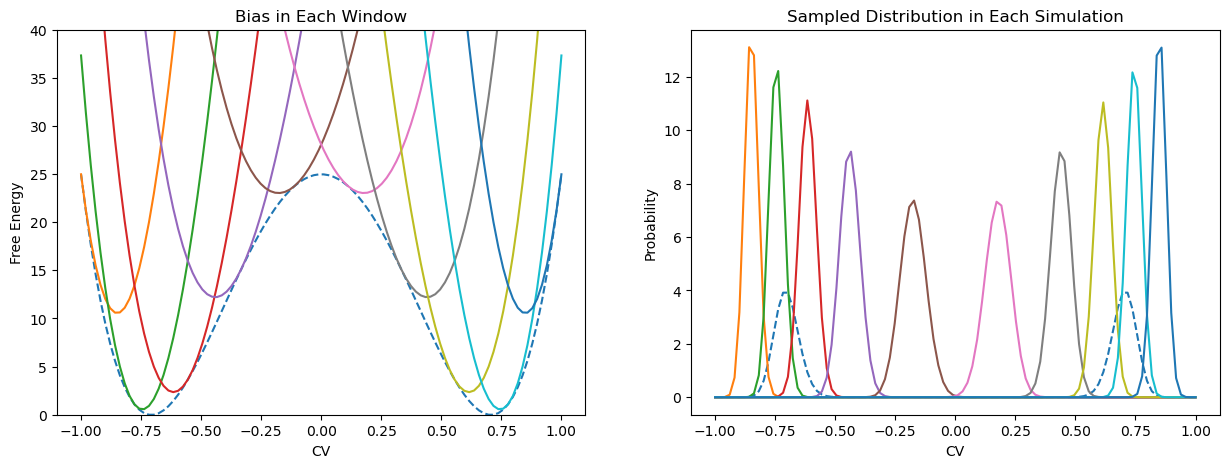

In [40]:
# Plot results from previous cell.

fig = plt.figure(figsize=(15,5))

x_vals = multi_umb.replicas[0].x_vals
fes = deep_fes(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
prob_dist /= np.sum(prob_dist*0.02)

ax1 = fig.add_subplot(121)
ax1.plot(x_vals,fes,ls='dashed',label='Underlying FES')

ax2 = fig.add_subplot(122)
ax2.plot(x_vals, prob_dist, ls='dashed', label='Underlying Probability')

for i in range(multi_umb.numbrellas):
    ax1.plot(x_vals,multi_umb.replicas[i].bias + fes)
    hist, _ = np.histogram(multi_umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/np.sum(hist*0.02)
    ax2.plot(x_vals,hist)

ax1.set_ylim(0,40)
ax1.set_xlabel('CV')
ax1.set_ylabel('Free Energy')
ax1.set_title('Bias in Each Window')

ax2.set_xlabel('CV')
ax2.set_ylabel('Probability')
ax2.set_title('Sampled Distribution in Each Simulation')

The sampled results allow us to compute $n_{ij}$ and $N_i$ for WHAM. Let's analyze our trajectories with WHAM now, and visualize the results.

In [41]:
wham = WHAM(multi_umb,iterations=1000)

/tmp/ipykernel_7415/3061041703.py:137: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


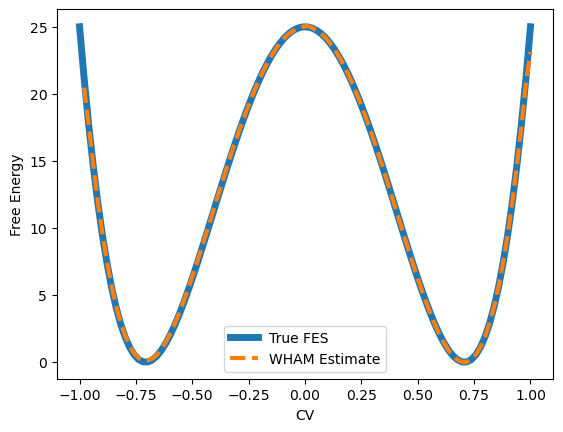

In [42]:
# Plot results from previous cell.

x_vals = multi_umb.replicas[0].x_vals
fes = deep_fes(x_vals)
plt.plot(x_vals,fes-fes.min(), label='True FES',lw=5)
plt.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
plt.xlabel('CV')
plt.ylabel('Free Energy')
plt.legend()

You can see how nicely we've been able to estimate the underlying free energy over (almost) all of CV space. (The sampling we missed on the edges could be corrected by placing bias potentials centered on the edges). The truth, however, is that we were only so successful because we selected an appropriate number of "umbrellas" with the correct values for kappa. Furthermore, we ran WHAM for 1000 iterations, more than enough for $f_i$ and $p_j^\circ$ to converge. Below, you can run the simulation again but this time try adjusting these parameters, as well as the total number of steps in the simulation. Then, answer the following questions:

1. What happens when there are too few umbrellas? What happens when there are too many?

2. What happens when kappa is too low? Too high? 

3. What happens when our simulation runs for too few steps?

4. How quickly do the WHAM results converge? How could we automatically detect if the results have converged?

In [14]:
numbrellas = 10
kappa = 500
nsteps_per_umbrella = 1000000
wham_iterations = 1000

/tmp/ipykernel_7415/3061041703.py:137: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


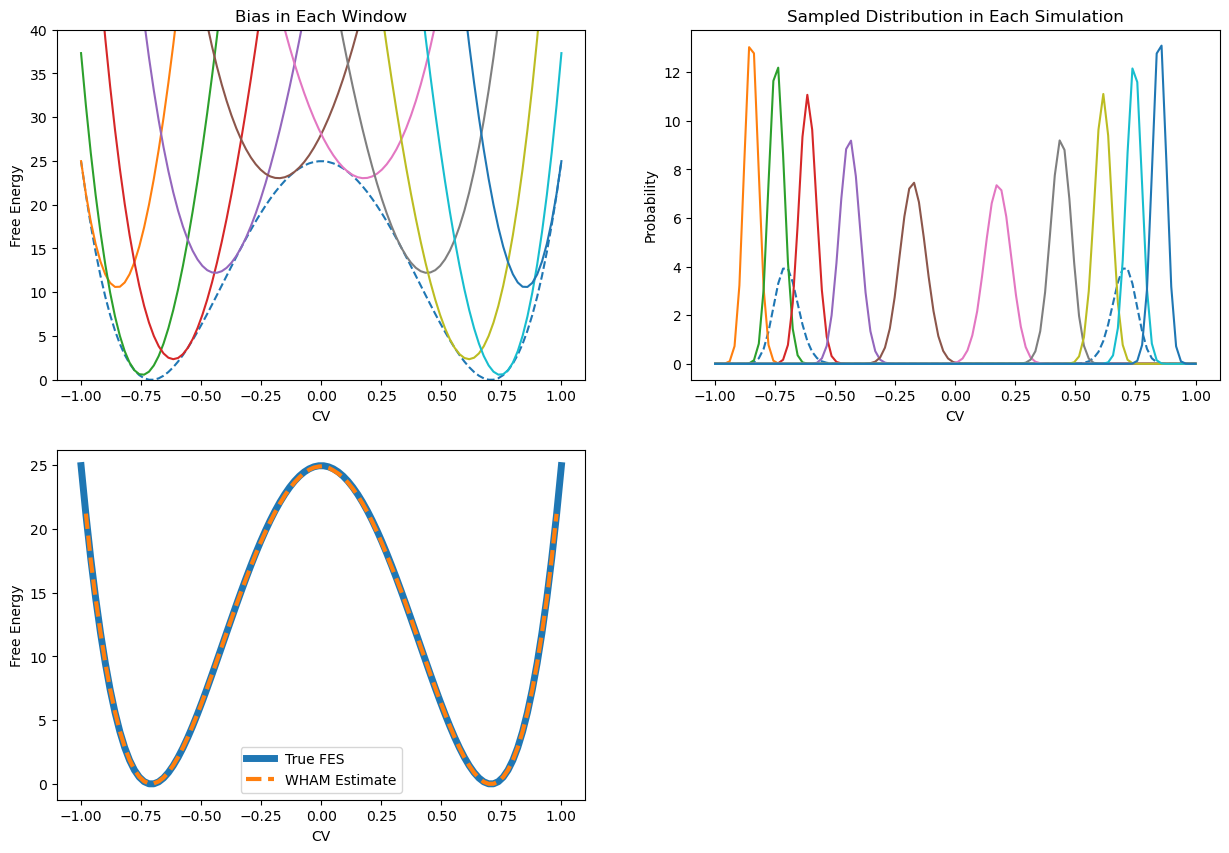

In [24]:
# run simulation

multi_umb = Umbrella_sampling(numbrellas=numbrellas,kappa=kappa,fes_func=deep_fes)
multi_umb.dynamics(nsteps_per_umbrella)

fig = plt.figure(figsize=(15,10))

x_vals = multi_umb.replicas[0].x_vals
fes = deep_fes(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
prob_dist /= np.sum(prob_dist*0.02)

ax1 = fig.add_subplot(221)
ax1.plot(x_vals,fes,ls='dashed',label='Underlying FES')

ax2 = fig.add_subplot(222)
ax2.plot(x_vals, prob_dist, ls='dashed', label='Underlying Probability')

for i in range(multi_umb.numbrellas):
    ax1.plot(x_vals,multi_umb.replicas[i].bias + fes)
    hist, _ = np.histogram(multi_umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/np.sum(hist*0.02)
    ax2.plot(x_vals,hist)

ax1.set_ylim(0,40)
ax1.set_xlabel('CV')
ax1.set_ylabel('Free Energy')
ax1.set_title('Bias in Each Window')

ax2.set_xlabel('CV')
ax2.set_ylabel('Probability')
ax2.set_title('Sampled Distribution in Each Simulation')

wham = WHAM(multi_umb,iterations=wham_iterations)

ax3 = fig.add_subplot(223)
ax3.plot(x_vals,fes,label='True FES',lw=5)
ax3.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
ax3.set_xlabel('CV')
ax3.set_ylabel('Free Energy')
ax3.legend()

## Appendix I: Free energy and probability.

In an isolated system, that is, one at constant energy, all microstates $i$ of the system are equally likely.

$$P_i = \frac{1}{\Omega(E)}$$

Where $\Omega(E)$ is the total number of states at energy $E$.

Now, imagine we introduce an infinitely large bath of Temperature T, and bring it into contact with our system. Energy within the smaller system is no longer conserved, but the energy of the system plus the bath still is.

$$E = E_{s} + E_{b}$$

$$E_{b} = E - E_{s}$$

Now we can describe the number of microstates of the bath in terms of the energy of the inner system.

$$\Omega_{b}(E_{b}) = \Omega_{b}(E - E_{s})$$

Clearly, the probability of a microstate $i$ occurring should be proportional to the number of microstates that have an inner-system energy of $E_{sys,i}$.

$$P_i \propto \Omega_{b,i}(E - E_{s,i})$$

This proportionality becomes an equality if we divide by the total number of microstates possible at any energy.

$$P_i = \frac{\Omega_i(E - E_{sys,i})}{\sum_i \Omega_i(E - E_{sys,i})}$$

We really need some idea of the functional form of $\Omega_i(E - E_{sys,i})$ for this to be useful to us, so we take the Taylor series expansion. Given that we care about a limit in which our bath is infinitely large, we can assume that $E - E_{sys,i} \approx E$, and thus we choose to center our expansion around energy $E$. Furthermore, it is known *a posteriori* that $\Omega$ varies wildly with changing energy, so it is more useful to expand $\ln \Omega(E - E_{sys,i})$.

$$\ln \Omega(E - E_{sys,i}) \approx \ln \Omega(E) - E_{sys,i} \frac{\mathrm{d} \ln \Omega(E - E_{sys,i})}{\mathrm{d} (E - E_{sys,i})} \Big|_{E - E_{sys,i} = E}$$

Within this first-order Taylor expansion we recognize something of the form $\frac{\mathrm{d} \ln \Omega(E)}{\mathrm{d} (E)}$. In statistical mechanics, it is a well known identity that $\beta = \frac{1}{k_BT} = \frac{\mathrm{d} \ln \Omega(E)}{\mathrm{d} (E)}$. We will utilize this identity to simplify the equation above.

$$\ln \Omega(E - E_{sys,i}) \approx \ln \Omega(E) - \frac{E_{sys,i}}{k_BT}$$

$$\Omega(E - E_{sys,i}) \approx \Omega(E) e^{-\frac{E_{sys,i}}{k_BT}}$$

Now we can plug this form for $\Omega$ back into our equation for $P_i$, recognizing that the constant term $\Omega(E)$ will disappear because it is in both the numerator and every term in the denominator.

$$P_i = \frac{e^{-\frac{E_{sys,i}}{k_BT}}}{\sum_i e^{-\frac{E_{sys,i}}{k_BT}}}$$